# Preconditioning for GMRES

In [1]:
using FundamentalsNumericalComputation

Here is a large sparse matrix.

In [43]:
A = 2.5I + sprand(40000,40000,0.0004);

Without a preconditioner, GMRES takes a large number of iterations. 

In [44]:
b = rand(40000)
IterativeSolvers.gmres(A,b,maxiter=30,reltol=1e-10,restart=50,log=true);  # force compilation
time_plain = @elapsed x,hist1 = IterativeSolvers.gmres(A,b,maxiter=300,reltol=1e-10,restart=50,log=true);
@show time_plain;

time_plain = 0.545099669


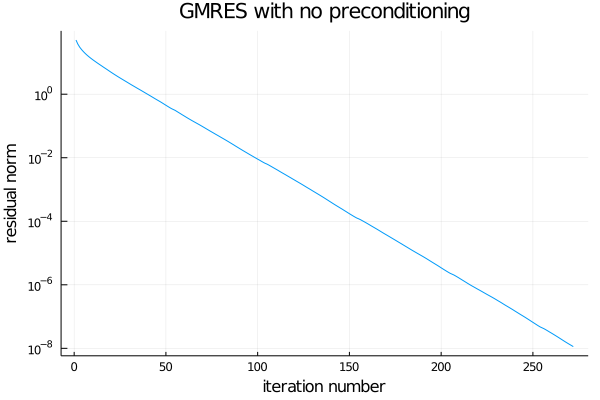

In [45]:
plot(hist1[:resnorm],label="", 
    title="GMRES with no preconditioning",
    xaxis=("iteration number"), yaxis=(:log10,"residual norm") )

This version of incomplete $LU$ factorization drops all sufficiently small values (i.e., replaces them with zeros). This keeps the number of nonzeros in the factors under control.

In [49]:
iLU = ilu(A,τ=0.3);
@show nnz(A),nnz(iLU.L);

(nnz(A), nnz(iLU.L)) = (680738, 283259)


It does _not_ produce a true factorization of $A$. However, it's close enough to serve as "approximate inverse" in a preconditioner. The actual preconditioning matrix is $\mathbf{M}=\mathbf{L}\mathbf{U}$. However, we just supply the factorization as a left preconditioner, since the preconditioning step is to solve a system with the matrix $\mathbf{M}$.

In [50]:
IterativeSolvers.gmres(A,b,Pl=iLU,maxiter=300,reltol=1e-10,restart=50,log=true);
time_prec = @elapsed x,hist2 = IterativeSolvers.gmres(A,b,Pl=iLU,maxiter=300,reltol=1e-10,restart=50,log=true);
@show time_prec;

time_prec = 0.295443601


The preconditioning is moderately successful in this case.

In [52]:
@show speedup = time_plain / time_prec;

speedup = time_plain / time_prec = 1.8450210705358954


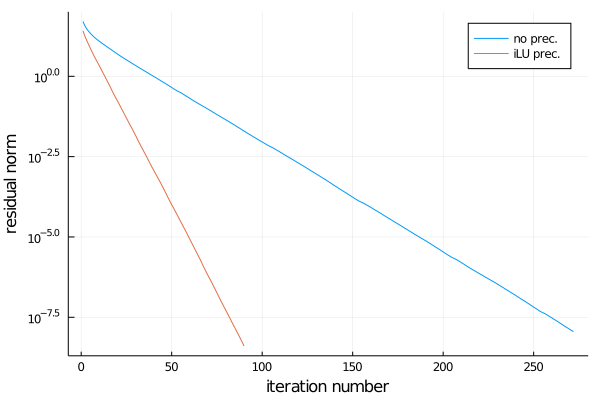

In [51]:
plot(hist1[:resnorm],label="no prec.", 
    xaxis=("iteration number"), yaxis=(:log10,"residual norm") )
plot!(hist2[:resnorm],label="iLU prec.")

We made each GMRES iteration a bit slower because of the need to apply the preconditioner (here, by solving sparse triangular systems). However, there are a lot fewer iterations needed, giving an improvement in the  total time.